In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import tqdm
import os
import sklearn.model_selection
import sklearn.ensemble
import sklearn.svm
import sklearn.utils
import os
import librosa
import pandas as pd
import scipy as sp
import scipy.io.wavfile
from skimage.util.shape import view_as_windows

import warnings
import matplotlib.pyplot as plt

In [17]:
def df_to_feat_idx_wind(feat_df, key, fun, window_length, return_label=False):
    X = np.asarray(feat_df[key].values)
    Y_v = np.asarray(feat_df['y_value'])
    Y_l = np.asarray(feat_df['y_label'])
    XX = []
    YY_v = []
    YY_l = []
    wind_number = []
    if key == 'mfcc':
        for i, x in enumerate(X):
            x = np.asarray(x).T.squeeze()
            xw = view_as_windows(x, window_shape=(window_length, x.shape[1]),
                                 step=(int(window_length * 0.5), x.shape[1])).squeeze()
            fun_xw = fun(xw).squeeze()
            XX.append(fun_xw)
            if return_label:
                YY_v.append(np.repeat(Y_v[i], fun_xw.shape[0]))
                YY_l.append(np.repeat(Y_l[i], fun_xw.shape[0]))
                wind_number.append(fun_xw.shape[0])

        XX = np.asarray(np.concatenate(XX, axis=0))        
        
        if return_label:
            YY_v = np.asarray(np.concatenate(YY_v, axis=0))
            YY_l = np.asarray(np.concatenate(YY_l, axis=0))
    else:
        for i, x in enumerate(X):
            x = np.asarray(x).squeeze()
            xw = view_as_windows(x, window_shape=(window_length,), step=int(window_length * 0.5))
            fun_xw = fun(xw)
            fun_xw = fun_xw.reshape(-1, 1)
            XX.append(fun_xw)
            if return_label:
                YY_v.append(np.repeat(Y_v[i], fun_xw.shape[0]))
                YY_l.append(np.repeat(Y_l[i], fun_xw.shape[0]))
                wind_number.append(fun_xw.shape[0])


        XX = np.asarray(np.concatenate(XX, axis=0))
        if return_label:
            YY_v = np.asarray(np.concatenate(YY_v, axis=0))
            YY_l = np.asarray(np.concatenate(YY_l, axis=0))


    return XX, YY_v, YY_l, wind_number



def df_to_feat_idx(feat_df, key, fun):
    # take only samples of the key feature over the rms threshold
    X = feat_df.apply(lambda x: np.asarray(x[key]).squeeze().T[np.where(x['rms_idx'] == 1)].T, axis=1)
    # apply the function
    X = X.apply(fun)
    X = X.apply(lambda x: np.reshape(x, (1, -1)))
    X = np.concatenate(X).squeeze()
    if len(X.shape) == 1:
        X.shape += (1,)
    return X

In [18]:
def get_jaccard_sim(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [19]:
train_data_path = '/nas/home/cborrelli/speech_forensics/notebook/pickle/sphinx/features_train-clean-100.pkl'
feat_train_df = pd.read_pickle(train_data_path)


In [20]:
rms_th = 0
norm = 'zscore'
win_min_max = True
n_win_min = 50
n_win_max = 250
filter_outliers = True

In [29]:
feat_train_df

,path,noise,snr,mfcc,sfl,sc,sroff,zcr,rms,y_value,y_label
0,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-253.9422948218842, -253.4260268914878, -25...","[0.018817345, 0.01814022, 0.0117125865, 0.0126...","[1353.4094579568955, 1358.9616923648862, 1254....","[2900.0, 3120.0, 2680.0, 2760.0, 2300.0, 2820....","[0.04125, 0.07875, 0.0825, 0.0875, 0.08, 0.077...","[0.040383443, 0.043989692, 0.051003907, 0.0560...",0.000000,1
1,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-306.327545853318, -306.26975195002865, -30...","[0.01878596, 0.01786194, 0.011918421, 0.012765...","[1352.6198126711097, 1358.7462149685553, 1254....","[2880.0, 3140.0, 2680.0, 2760.0, 2300.0, 2800....","[0.04125, 0.07875, 0.0825, 0.0875, 0.08, 0.077...","[0.023699123, 0.025779132, 0.029883819, 0.0328...",0.000000,1
2,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-311.7976233322734, -312.63761554854455, -3...","[0.01860241, 0.018572556, 0.012049843, 0.01302...","[1351.028536955855, 1353.2617584528975, 1256.2...","[2880.0, 3080.0, 2680.0, 2800.0, 2300.0, 2820....","[0.04125, 0.07875, 0.0825, 0.0875, 0.0825, 0.0...","[0.022335935, 0.02418832, 0.027991889, 0.03076...",0.000000,1
3,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-272.39154010495946, -272.0611338354306, -2...","[0.01874783, 0.017311225, 0.011567401, 0.01228...","[1352.5505784083362, 1358.7635606362323, 1254....","[2880.0, 3140.0, 2680.0, 2760.0, 2300.0, 2800....","[0.04125, 0.07875, 0.0825, 0.0875, 0.08, 0.08,...","[0.033473797, 0.036410995, 0.042206362, 0.0463...",0.100000,1
4,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-319.1679484928125, -319.44680813471416, -3...","[0.01842959, 0.018852752, 0.011963086, 0.01264...","[1349.3451808879763, 1361.4334821540979, 1254....","[2880.0, 3140.0, 2680.0, 2760.0, 2320.0, 2840....","[0.04125, 0.07375, 0.0775, 0.0875, 0.0825, 0.0...","[0.020718517, 0.022575779, 0.026233373, 0.0288...",0.000000,1
5,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-304.0039010330863, -303.6567389250647, -30...","[0.018653587, 0.019451872, 0.011748297, 0.0131...","[1356.6216675432952, 1356.1367127649987, 1256....","[2900.0, 3100.0, 2680.0, 2760.0, 2300.0, 2800....","[0.04125, 0.07875, 0.0775, 0.0825, 0.0775, 0.0...","[0.024285084, 0.026496395, 0.030556986, 0.0335...",0.000000,1
6,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-294.84931427411084, -294.65644553873386, -...","[0.018811716, 0.017977435, 0.011710711, 0.0127...","[1352.7867417326888, 1358.9391140812018, 1255....","[2880.0, 3140.0, 2680.0, 2760.0, 2300.0, 2800....","[0.04125, 0.07875, 0.0825, 0.0875, 0.08, 0.077...","[0.026635615, 0.02897324, 0.03358477, 0.036921...",0.125000,1
7,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-307.670016347402, -307.6310424534651, -305...","[0.018794134, 0.017946007, 0.011339434, 0.0125...","[1352.819171612682, 1358.809421547129, 1254.97...","[2880.0, 3140.0, 2680.0, 2760.0, 2300.0, 2820....","[0.04125, 0.07875, 0.0825, 0.0875, 0.08, 0.077...","[0.023373662, 0.02542561, 0.029473074, 0.03240...",0.000000,1
8,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-298.779527904524, -298.94839308566276, -29...","[0.018778889, 0.01811295, 0.01145595, 0.012521...","[1353.1326407853521, 1358.9470959917276, 1254....","[2880.0, 3140.0, 2680.0, 2760.0, 2300.0, 2800....","[0.04125, 0.07875, 0.0825, 0.0875, 0.08, 0.077...","[0.025584742, 0.027829763, 0.032259647, 0.0354...",0.090909,1
9,/nas/home/cborrelli/speech_forensics/dataset/t...,train,0,"[[[-296.2261067014843, -294.548262933944, -293...","[0.0158747, 0.020011565, 0.012540805, 0.012613...","[1342.3167156081956, 1361.6018911734227, 1257....","[2880.0, 3140.0, 2680.0, 2760.0, 2300.0, 2800....","[0.04125, 0.07375, 0.0775, 0.0875, 0.08, 0.077...","[0.026526073, 0.028885774, 0.03350465, 0.03683...",0.058824,1


In [30]:
feat_df = feat_train_df[feat_train_df['noise']=='speech1']

In [31]:
#feat_df = pd.concat([dev_feat, test_feat, train_feat], ignore_index=True)

feat_df = sklearn.utils.shuffle(feat_df, random_state=0).reset_index(drop=True)

# Apply rms threshold
feat_df['rms_idx'] = feat_df['rms'].apply(lambda x: x >= rms_th * (x.max() - x.min()) + x.min())
feat_df['n_win'] = feat_df['rms'].apply(lambda x: len(x))

# Apply threshold on window number
if win_min_max:
    n_win_min = 50
    n_win_max = 250
    feat_df = feat_df.loc[
        np.where(np.logical_and(feat_df['n_win'] >= n_win_min, feat_df['n_win'] <= n_win_max))[0]].reset_index()

# Filter out outliers
if filter_outliers:
    idx_0 = (feat_df['y_value'] >= 0) & (feat_df['y_value'] < 0.35) & (feat_df['snr'] == 0)
    idx_2 = (feat_df['y_value'] >= 0) & (feat_df['y_value'] < 0.4) & (feat_df['snr'] == 2)
    idx_5 = (feat_df['y_value'] >= 0.1) & (feat_df['y_value'] < 0.5) & (feat_df['snr'] == 5)
    idx_7 = (feat_df['y_value'] >= 0.1) & (feat_df['y_value'] < 0.7) & (feat_df['snr'] == 7)
    idx_10 = (feat_df['y_value'] >= 0.25) & (feat_df['y_value'] < 0.7) & (feat_df['snr'] == 10)
    idx_12 = (feat_df['y_value'] >= 0.35) & (feat_df['y_value'] < 1.1) & (feat_df['snr'] == 12)
    idx_15 = (feat_df['y_value'] >= 0.4) & (feat_df['y_value'] < 1.1) & (feat_df['snr'] == 15)

    idx = idx_0 | idx_2 | idx_5 | idx_7 | idx_10 | idx_12 | idx_15

    feat_df = feat_df.loc[np.where(idx == 1)].reset_index()

In [32]:
# Compute feature matrix
key_list = ['mfcc', 'sfl', 'sc', 'sroff', 'zcr', 'rms']

X_mean_list = []
for key in key_list:
    X_mean_list += [df_to_feat_idx(feat_df, key, lambda x: np.mean(x, axis=-1))]
X_mean = np.concatenate(X_mean_list, axis=1)

X_std_list = []
for key in key_list:
    X_std_list += [df_to_feat_idx(feat_df, key, lambda x: np.std(x, axis=-1))]
X_std = np.concatenate(X_std_list, axis=1)

X_max_list = []
for key in key_list:
    X_max_list += [df_to_feat_idx(feat_df, key, lambda x: np.max(x, axis=-1))]
X_max = np.concatenate(X_max_list, axis=1)

X_min_list = []
for key in key_list:
    X_min_list += [df_to_feat_idx(feat_df, key, lambda x: np.min(x, axis=-1))]
X_min = np.concatenate(X_min_list, axis=1)

X = np.concatenate([X_mean, X_std, X_max, X_min], axis=1)










# Retrieve labels
y_cl_multi = np.array(feat_df['y_label'], dtype=np.float) - 1  # labels for classification
y_cl = np.array(feat_df['y_value'], dtype=np.float) >= 0.5  # labels for classification
y_rg = np.array(feat_df['y_value'], dtype=np.float)  #  values for regression

# Normalize features
if norm == 'zscore':
    X_norm = (X - X.mean(axis=0)) / X.std(axis=0)  # z-score
elif norm == 'minmax':
    X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))  # [0, 1]
else:
    X_norm = X

# Remove nan and inf
X_norm[np.where(np.isnan(X_norm))] = 0
X_norm[np.where(np.isinf(X_norm))] = 0

In [33]:
print('min(X_norm) = {:.3f}'.format(X_norm.min()))
print('max(X_norm) = {:.3f}'.format(X_norm.max()))
print('mean(X_norm) = {:.3f}'.format(X_norm.mean()))
print('std(X_norm) = {:.3f}'.format(X_norm.std()))

min(X_norm) = -8.057
max(X_norm) = 19.395
mean(X_norm) = 0.000
std(X_norm) = 1.000


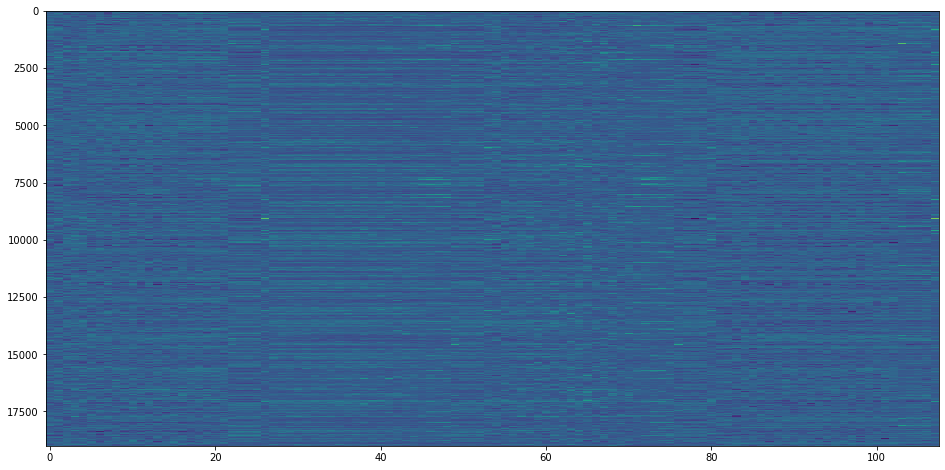

In [25]:
plt.figure(figsize=(16,8))
plt.imshow(X_norm, aspect='auto')